<a href="https://colab.research.google.com/github/SawsanYusuf/Housing-in-Colombia/blob/main/3_Price_with_neighborhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+3"><strong>Predicting Price with Neighborhood</strong></font>

In [ ]:
import warnings
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning)

In the last notebook, we created a model that used location — represented by latitude and longitude — to predict price. In this notebook, we’re going to use a different representation for location:
**neighborhood**.

# Prepare Data

## Import

In [ ]:
def wrangle(filepath):
    #import_csv
    df = pd.read_csv(filepath,index_col=[0])

    #subset to propertes in '"Capital Federal"'
    mask_ba= df["place_with_parent_names"].str.contains("Bogotá D.C")

    #subset for  '"apartment"'
    mask_apt=df["property_type"] == "house"

    #subset where '"price_aprox_usd"' < 400,000
    mask_price= df["price_aprox_usd"] < 400_000

    df= df[mask_ba & mask_apt & mask_price]

    #Remove the outliers by '"surface_covered_in_m2"'
    low, high= df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area =df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]

    #split the '"lat-lon"'
    df[["lat" ,"lon"]]= df["lat-lon"].str.split(",", expand= True).astype(float)
    df.drop(columns="lat-lon", inplace = True)

    return df

In the last notebook, we used our wrangle function to import two CSV files as DataFrames. But what
if we had hundreds of CSV files to import? Wrangling them one-by-one wouldn’t be an option. So
let’s start with a technique for reading several CSV files into a single DataFrame.

The first step is to gather the names of all the files we want to import. We can do this using pattern
**matching**.

Let's use `glob` to create a list that contains the filenames for all the Colombia real
estate CSV files in the data directory. Assign this list to the variable name `files`.

In [ ]:
files = glob("/content/colombia-real-estate-*.csv")
files

['/content/colombia-real-estate-2.csv',
 '/content/colombia-real-estate-5.csv',
 '/content/colombia-real-estate-1.csv',
 '/content/colombia-real-estate-3.csv',
 '/content/colombia-real-estate-4.csv']

The next step is to read each of the CSVs in files into a DataFrame, and put all of those
DataFrames into a list. What’s a good way to iterate through files so we can do this? **A for
loop!**

We use our wrangle function in a for loop to create a list named frames. The list
will contain the cleaned DataFrames created from the CSV filenames we collected in files.

In [ ]:
frames = []
for file in files:
   df= wrangle(file)
   frames.append(df)
len(frames)

5

The final step is to use pandas to combine all the DataFrames in frames using `concat()` method.

In [ ]:
df = pd.concat(frames, ignore_index= True)
print(df.shape)
df.head()

(4126, 17)


,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,house,|Colombia|Bogotá D.C|Kennedy|,440000000.0,COP,4.434438e+08,148567.33,161.0,161.0,922.778447,2.732919e+06,NaN,4.0,NaN,http://kennedy-bogota-d-c.properati.com.co/k4o...,4.631,-74.147
1,sell,house,|Colombia|Bogotá D.C|Rafael Uribe Uribe|,334900000.0,COP,3.375212e+08,113080.00,384.0,131.0,294.479167,2.556489e+06,3.0,10.0,NaN,http://rafael-uribe-uribe-bogota-d-c.properati...,4.585,-74.123
2,sell,house,|Colombia|Bogotá D.C|Suba|,350000000.0,COP,3.527394e+08,118178.56,112.0,112.0,1055.165714,3.125000e+06,NaN,3.0,NaN,http://suba-bogota-d-c.properati.com.co/k4qt_v...,4.747,-74.062
3,sell,house,|Colombia|Bogotá D.C|Usaquén|,910000000.0,COP,9.171224e+08,307264.26,NaN,164.0,NaN,5.548780e+06,8.0,3.0,NaN,http://usaquen-bogota-d-c.properati.com.co/k4r...,4.705,-74.044
4,sell,house,|Colombia|Bogotá D.C|Suba|,980000000.0,COP,9.876703e+08,330899.98,190.0,190.0,1741.578842,5.157895e+06,NaN,2.0,NaN,http://suba-bogota-d-c.properati.com.co/k4rx_v...,4.715,-74.095


We can now clean and combine as many CSV files as our computer can handle.

## Explore

Looking through the output from the `df.head()` cell above, there’s a little bit more cleaning we
need to do before we can work with the neighborhood information in this dataset.

We need to modify our wrangle function to create a new feature `"neighborhood"`. We can
find the neighborhood for each property in the `"place_with_parent_names"` column. For example, a property with the place name `"|Colombia|Bogotá D.C|Kennedy|"` is located in the
neighborhood is `"Kennedy"`. Also, our function should drop the `"place_with_parent_names"` column.

The final version of our wrangle function:

In [ ]:
def wrangle(filepath):
    #import_csv
    df = pd.read_csv(filepath,index_col=[0])

    #subset to propertes in '"Capital Federal"'
    mask_ba= df["place_with_parent_names"].str.contains("Bogotá D.C")

    #subset for  '"apartment"'
    mask_apt=df["property_type"] == "house"

    #subset where '"price_aprox_usd"' < 400,000
    mask_price= df["price_aprox_usd"] < 400_000

    df= df[mask_ba & mask_apt & mask_price]

    #Remove the outliers by '"surface_covered_in_m2"'
    low, high= df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area =df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]

    #split the '"lat-lon"'
    df[["lat" ,"lon"]]= df["lat-lon"].str.split(",", expand= True).astype(float)
    df.drop(columns="lat-lon", inplace = True)

    #Extract neighborhood
    df["neighborhood"]= df["place_with_parent_names"].str.split("|",expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace= True)

    return df

In [ ]:
files = glob("/content/colombia-real-estate-*.csv")

frames = []
for file in files:
   df= wrangle(file)
   frames.append(df)

df = pd.concat(frames, ignore_index= True)
print(df.shape)
df.head()

(4126, 17)


,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,house,440000000.0,COP,4.434438e+08,148567.33,161.0,161.0,922.778447,2.732919e+06,NaN,4.0,NaN,http://kennedy-bogota-d-c.properati.com.co/k4o...,4.631,-74.147,Kennedy
1,sell,house,334900000.0,COP,3.375212e+08,113080.00,384.0,131.0,294.479167,2.556489e+06,3.0,10.0,NaN,http://rafael-uribe-uribe-bogota-d-c.properati...,4.585,-74.123,Rafael Uribe Uribe
2,sell,house,350000000.0,COP,3.527394e+08,118178.56,112.0,112.0,1055.165714,3.125000e+06,NaN,3.0,NaN,http://suba-bogota-d-c.properati.com.co/k4qt_v...,4.747,-74.062,Suba
3,sell,house,910000000.0,COP,9.171224e+08,307264.26,NaN,164.0,NaN,5.548780e+06,8.0,3.0,NaN,http://usaquen-bogota-d-c.properati.com.co/k4r...,4.705,-74.044,Usaquén
4,sell,house,980000000.0,COP,9.876703e+08,330899.98,190.0,190.0,1741.578842,5.157895e+06,NaN,2.0,NaN,http://suba-bogota-d-c.properati.com.co/k4rx_v...,4.715,-74.095,Suba


## Split

Let's create our feature matrix `X_train` and target vector `y_train`. X_train should
contain one feature: `"neighborhood"`. our target is `"price_aprox_usd"`.

In [ ]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

# Build Model

## Baseline

Here, we must calculate the baseline mean absolute error for our model.

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 66403.66484730973
Baseline MAE: 86347.16145862668


## Iterate

If you try to fit a `LinearRegression` predictor to your training data at this point, you’ll get an
error that looks like this:

**ValueError: could not convert string to float**

What does this mean? When you fit a linear regression model, you’re asking scikit-learn to perform
a mathematical operation. The problem is that our training set contains neighborhood information
in non-numerical form. In order to create our model we need to encode that information so that
it’s represented numerically. The good news is that there are lots of transformers that can do this.
Here, we’ll use the one from the Category Encoders library, called a **OneHotEncoder**.

We need to bring the `OneHotEncoder` into our pipeline.
So, let's Create a pipeline named model that contains a `OneHotEncoder` transformer and a
`LinearRegression` predictor. Then fit your model to the training data.

In [ ]:
model = make_pipeline(
        OneHotEncoder(use_cat_names= True),
        LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('linearregression', LinearRegression())])

## Evaluate

In [ ]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 84955.22


# Results

If we write out the equation for our model, it’ll be too big to fit on the screen. That’s because,
when we used the OneHotEncoder to encode the neighborhood data, we created a much wider
DataFrame, and each column/feature has it’s own coefficient in our model’s equation.
This is important to keep in mind for two reasons.

First, it means that this is a high-dimensional
model. Instead of a 2D or 3D plot, we’d need a 20-dimensional plot to represent it, which is
impossible! Second, it means that we’ll need to extract and represent the information for our
equation a little differently than before. Let’s start by getting our intercept and coefficient.

In [ ]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])

coefficients len: 20
[2.88737932e+18 2.88737932e+18 2.88737932e+18 2.88737932e+18
 2.88737932e+18]


Let's also extract the feature names of our encoded data from the `OneHotEncoder` in our
model.

In [ ]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])

features len: 20
['neighborhood_Kennedy' 'neighborhood_Rafael Uribe Uribe'
 'neighborhood_Suba' 'neighborhood_Usaquén' 'neighborhood_Chapinero']


We have coefficients and feature names, and now we need to put them together. For that, we’ll use
a Series.

In [ ]:
feat_imp = pd.Series(coefficients, feature_names)
feat_imp.head()

neighborhood_Kennedy               2.887379e+18
neighborhood_Rafael Uribe Uribe    2.887379e+18
neighborhood_Suba                  2.887379e+18
neighborhood_Usaquén               2.887379e+18
neighborhood_Chapinero             2.887379e+18
dtype: float64

To be clear, it’s definitely not a good idea to show this long equation to an audience, but let’s print
it out just to check our work. Since there are so many terms to print, we’ll use a for loop.

In [ ]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = -2.8873793174012006e+18
+ (2.8873793174012513e+18 * neighborhood_Kennedy)
+ (2.8873793174012303e+18 * neighborhood_Rafael Uribe Uribe)
+ (2.8873793174012826e+18 * neighborhood_Suba)
+ (2.8873793174012733e+18 * neighborhood_Usaquén)
+ (2.887379317401255e+18 * neighborhood_Chapinero)
+ (2.887379317401254e+18 * neighborhood_Fontibón)
+ (2.887379317401263e+18 * neighborhood_La Candelaria)
+ (2.887379317401306e+18 * neighborhood_Usme)
+ (2.8873793174012483e+18 * neighborhood_Teusaquillo)
+ (2.887379317401269e+18 * neighborhood_Barrios Unidos)
+ (2.8873793174012416e+18 * neighborhood_Santa Fe)
+ (2.8873793174012447e+18 * neighborhood_Engativa)
+ (2.8873793174012493e+18 * neighborhood_Puente Aranda)
+ (2.8873793174012923e+18 * neighborhood_Los Mártires)
+ (2.8873793174012703e+18 * neighborhood_Bosa)
+ (2.887379317401235e+18 * neighborhood_Tunjuelito)
+ (2.887379317401378e+18 * neighborhood_)
+ (2.8873793174012677e+18 * neighborhood_Ciudad Bolívar)
+ (2.8873793174012564e+18 * neighborh

To avoid the **overfitting**, let's change the predictor in our model to `Ridge`, and retrain it. Then evaluate
the model’s training performance.

In [ ]:
model = make_pipeline(
       OneHotEncoder(use_cat_names= True),
       Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [ ]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 84117.51


In [ ]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
feature_names = model.named_steps["onehotencoder"].get_feature_names()

feat_imp = pd.Series(coefficients, feature_names)

print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 64163.29
+ (-9708.33 * neighborhood_Kennedy)
+ (-21069.93 * neighborhood_Rafael Uribe Uribe)
+ (20720.22 * neighborhood_Suba)
+ (9538.93 * neighborhood_Usaquén)
+ (-15251.42 * neighborhood_Chapinero)
+ (-16635.07 * neighborhood_Fontibón)
+ (-9936.81 * neighborhood_La Candelaria)
+ (33466.01 * neighborhood_Usme)
+ (-20229.9 * neighborhood_Teusaquillo)
+ (-2051.76 * neighborhood_Barrios Unidos)
+ (-27657.57 * neighborhood_Santa Fe)
+ (-24089.59 * neighborhood_Engativa)
+ (-19556.84 * neighborhood_Puente Aranda)
+ (21243.41 * neighborhood_Los Mártires)
+ (1526.46 * neighborhood_Bosa)
+ (-26428.73 * neighborhood_Tunjuelito)
+ (97394.36 * neighborhood_)
+ (-1435.5 * neighborhood_Ciudad Bolívar)
+ (-11760.85 * neighborhood_San Cristobal)
+ (21922.88 * neighborhood_Antonio Nariño)


We’re back on track with our model, so let’s create a visualization that will help a non-technical
audience understand what the most important features for our model in predicting apartment price.

Let's reate a horizontal bar chart that shows the top 15 coefficients for your model, based
on their absolute value.

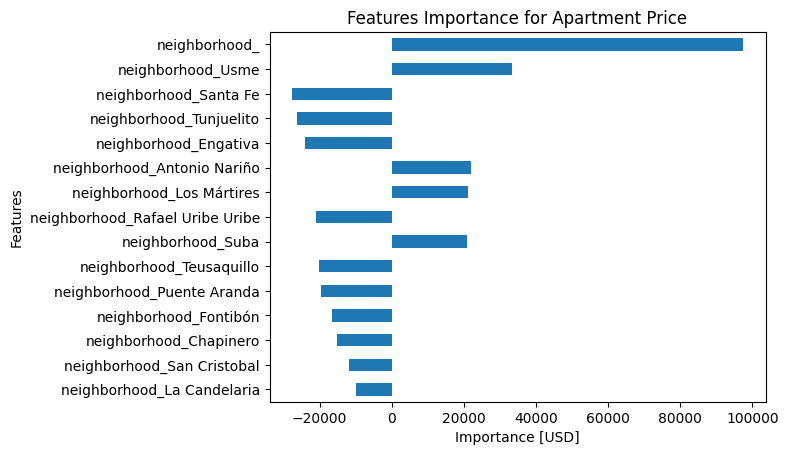

In [ ]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Features")
plt.title("Features Importance for Apartment Price");